In [27]:
import gc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as rxr
from rioxarray.merge import merge_arrays
from rioxarray.merge import merge_datasets
from osgeo import gdal
from xarray.ufuncs import logical_or  as xr_or
import yaml
from datetime import datetime
import rasterio 

Selecting Bands:

In [28]:
# Directory with Landsat scene data
#landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LC08_L2SR_082071_20211126_tmp_2/LC08_L2SR_082071_20211126/'
landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LC08_L2SR_076071_20200910_tmp/LC08_L2SR_076071_20200910/'

# Select the QA Pixel Band
#qa_band = landsat_folder + 'LC08_L2SR_082071_20211126_20211201_02_T1_QA_PIXEL.tif'
qa_band = landsat_folder + 'LC08_L2SR_076071_20200910_20200923_02_T2_QA_PIXEL.tif'


Bitmasking functions from dc_Mosaic with slight adjustments:

In [29]:
def ls8_unpack_qa(data_array, cover_type):
    """
    Function from dc_mosaic.py
    """
    boolean_mask = np.zeros(data_array.shape, dtype=bool)
    data_array = data_array.astype(np.int64)

    if cover_type == 'clear':
        # 6th bit is clear
        boolean_mask |=  ((data_array & 0b0000000001000000) != 0)
    elif cover_type == 'water':
        # 7th bit is water
        boolean_mask |= ((data_array & 0b0000000010000000) != 0)
    else:
        raise ValueError(f"Cover type {cover_type} not supported for Landsat 8 yet")
    return boolean_mask

def landsat_qa_clean_mask(pixel_qa_band, platform, cover_types):
    """
    Function from dc_mosaic.py
    """
    processing_options = {
        #"LANDSAT_4": ls4_unpack_qa,
        #"LANDSAT_5": ls5_unpack_qa,
        #"LANDSAT_7": ls7_unpack_qa,
        "LANDSAT_8": ls8_unpack_qa,
        #"SENTINEL_2": sen2_unpack_qa
    }

    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    
    if platform == "SENTINEL_2":
        for i, cover_type in enumerate(cover_types):
            cover_type_clean_mask = processing_options[platform](pixel_qa_band, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    
    else: 
        for i, cover_type in enumerate(cover_types):
            print(f'running cover_type: {cover_type}')
            cover_type_clean_mask = processing_options[platform](pixel_qa_band, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)

    return clean_mask

def rename_bands(in_xr, des_bands, position):
    in_xr.name = des_bands[position]
    return in_xr

Prepare data:

In [30]:
# Read the QA Pixel Band as array
qa_arr = gdal.Open(qa_band).ReadAsArray()

# Read yml metadata
yml = landsat_folder + 'datacube-metadata.yaml'
with open (yml) as stream: yml_meta = yaml.safe_load(stream) 

# Define desired bands
des_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

# Read bands with rioxarray
o_bands_data = [ rxr.open_rasterio(landsat_folder + yml_meta['image']['bands'][b]['path']) for b in des_bands ] 

# Access the pixel_qa band for bit masking
pixel_qa_band = o_bands_data[6]

for i in o_bands_data: i.close() # close the files

Run bitmasking and visualize:

running cover_type: clear
running cover_type: water


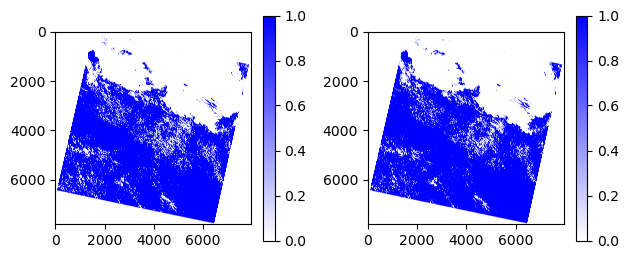

In [31]:
# Run the clean mask function for clear and water
clear_mask = landsat_qa_clean_mask(pixel_qa_band, 'LANDSAT_8', cover_types=['clear'])
water_mask = landsat_qa_clean_mask(pixel_qa_band, 'LANDSAT_8', cover_types=['water'])

# Apply the masks to the scene
# TODO: Actually apply the masks - figure out how to do this if not using xr.merge because of image issues
#clear_scene = bands_data.where(clear_mask)
#water_scene = bands_data.where(water_mask)

# Write the masks to tif
clear_mask.rio.to_raster("clear_mask.tif", dtype="uint8")
water_mask.rio.to_raster("water_mask.tif", dtype="uint8")


# Visualize masks
fig, axs = plt.subplots(1, 2)

# Define the colormap
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","blue"])

# Squeeze the mask arrays to visualize
clear_mask = np.squeeze(clear_mask)
water_mask = np.squeeze(water_mask)


# Visualize clear mask
clear_im = axs[0].imshow(clear_mask, cmap=custom_cmap)
plt.colorbar(clear_im, ax=axs[0], shrink=0.5)

# Visualize water mask
water_im = axs[1].imshow(water_mask, cmap=custom_cmap)
plt.colorbar(water_im, ax=axs[1], shrink=0.5)

plt.tight_layout()

In [32]:
with rasterio.open(qa_band) as src: print(src.profile)
print(clear_mask.dtype)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7956, 'height': 7811, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002695, 0.0, 175.026009549877,
       0.0, -0.0002695, -14.8484708908264), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
bool
